<a href="https://colab.research.google.com/github/santoshgurujula/Springboard/blob/master/TimeSeries_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, import the relevant modules
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 10,6

In [2]:
import tensorflow as tf 
tf.test.gpu_device_name()

''

In [3]:
tf.__version__

'2.3.0'

In [4]:
#pointing the path to google drive folder
%cd '/content/drive/My Drive/Springboard/data'
!ls

/content/drive/My Drive/Springboard/data
BOM500002.csv  BOM500013.csv  fig2.png
BOM500003.csv  BOM500014.csv  FinalStockData.csv
BOM500008.csv  BOM500020.csv  interpolating-timeseries-p1-pandas-fig1.png
BOM500009.csv  BOM500023.csv  nasdl.csv
BOM500010.csv  DJI.csv
BOM500012.csv  fig1.png


In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Springboard/data/FinalStockData.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Columns: 133 entries, Unnamed: 0 to Adj Close
dtypes: float64(131), int64(1), object(1)
memory usage: 895.8+ KB


In [6]:
dataset.head()

,Unnamed: 0,Date,Open_BOM500002,Open_BOM500003,Open_BOM500008,Open_BOM500009,Open_BOM500010,Open_BOM500012,Open_BOM500013,Open_BOM500014,Open_BOM500020,Open_BOM500023,High_BOM500002,High_BOM500003,High_BOM500008,High_BOM500009,High_BOM500010,High_BOM500012,High_BOM500013,High_BOM500014,High_BOM500020,High_BOM500023,Low_BOM500002,Low_BOM500003,Low_BOM500008,Low_BOM500009,Low_BOM500010,Low_BOM500012,Low_BOM500013,Low_BOM500014,Low_BOM500020,Low_BOM500023,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,...,% Deli. Qty to Traded Qty_BOM500003,% Deli. Qty to Traded Qty_BOM500008,% Deli. Qty to Traded Qty_BOM500009,% Deli. Qty to Traded Qty_BOM500010,% Deli. Qty to Traded Qty_BOM500012,% Deli. Qty to Traded Qty_BOM500013,% Deli. Qty to Traded Qty_BOM500014,% Deli. Qty to Traded Qty_BOM500020,% Deli. Qty to Traded Qty_BOM500023,Spread H-L_BOM500002,Spread H-L_BOM500003,Spread H-L_BOM500008,Spread H-L_BOM500009,Spread H-L_BOM500010,Spread H-L_BOM500012,Spread H-L_BOM500013,Spread H-L_BOM500014,Spread H-L_BOM500020,Spread H-L_BOM500023,Spread C-O_BOM500002,Spread C-O_BOM500003,Spread C-O_BOM500008,Spread C-O_BOM500009,Spread C-O_BOM500010,Spread C-O_BOM500012,Spread C-O_BOM500013,Spread C-O_BOM500014,Spread C-O_BOM500020,Spread C-O_BOM500023,Gross_Purchases,Gross_Sales,Net_Investment_INR,Net_Investment_USD,Conversion_Rate,High,Low,Open,Close,Volume,Adj Close
0,0,2017-01-02,1045.0,129.00,870.05,7.00,1275.00,21.9,15.50,2.50,49.05,NaN,1052.0,132.45,898.95,7.89,1275.0,22.00,16.08,2.50,49.90,NaN,1035.00,129.00,867.6,7.00,1214.15,21.50,14.86,2.30,48.35,NaN,1039.95,131.05,896.20,7.09,1219.25,21.60,15.30,2.37,...,59.65,12.15,87.01,21.24,77.39,38.58,82.68,27.28,NaN,17.00,3.45,31.35,0.89,60.85,0.50,1.22,0.20,1.55,NaN,-5.05,2.05,26.15,0.09,-55.75,-0.30,-0.20,-0.13,-0.25,NaN,2230.64,2796.67,-566.03,-83.29,67.9547,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2017-01-03,1069.9,132.30,900.00,7.04,1220.00,21.9,15.50,2.47,49.00,106.950000,1069.9,135.00,900.00,7.30,1222.0,21.90,15.70,2.48,49.80,106.950000,1037.90,132.00,882.9,7.04,1201.00,21.10,15.10,2.32,48.55,106.950000,1045.05,132.50,890.20,7.25,1215.25,21.70,15.32,2.43,...,37.15,24.99,89.13,54.61,89.96,64.98,80.71,44.10,100.000000,32.00,3.00,17.10,0.26,21.00,0.80,0.60,0.16,1.25,0.000000,-24.85,0.20,-9.80,0.21,-4.75,-0.20,-0.18,-0.04,-0.20,0.000000,867.26,1185.97,-318.71,-46.85,68.0225,19938.529297,19775.929688,19872.859375,19881.759766,339180000.0,19881.759766
2,2,2017-01-04,1050.0,134.15,892.00,7.13,1215.25,22.5,15.32,2.48,50.25,104.050000,1050.0,134.60,909.25,7.40,1225.0,22.75,15.44,2.50,51.90,104.050000,1033.50,131.25,890.0,7.11,1197.55,21.25,15.12,2.35,50.25,104.025000,1037.35,131.75,898.50,7.26,1212.50,22.75,15.28,2.47,...,61.49,24.11,83.89,92.28,74.31,84.28,96.69,31.95,100.000000,16.50,3.35,19.25,0.29,27.45,1.50,0.32,0.15,1.65,0.025000,-12.65,-2.40,6.50,0.13,-2.75,0.25,-0.04,-0.01,0.65,-0.025000,1863.97,2400.72,-536.75,-78.84,68.0864,19956.140625,19878.830078,19890.939453,19942.160156,280010000.0,19942.160156
3,3,2017-01-05,1051.9,132.00,905.00,7.02,1225.00,23.7,15.43,2.34,51.25,101.150000,1051.9,133.25,935.25,7.50,1225.0,23.85,15.52,2.49,54.40,101.150000,1029.55,130.00,900.0,7.02,1205.30,22.90,15.26,2.33,51.20,101.100000,1031.45,131.65,916.35,7.34,1216.55,23.85,15.48,2.41,...,59.06,27.79,72.79,23.37,73.78,76.37,69.64,32.58,100.000000,22.35,3.25,35.25,0.48,19.70,0.95,0.26,0.16,3.20,0.050000,-20.45,-0.35,11.35,0.32,-8.45,0.15,0.05,0.07,2.60,-0.050000,3534.18,4226.17,-691.99,-101.50,68.1791,19948.599609,19811.119141,19924.560547,19899.289062,269920000.0,19899.289062
4,4,2017-01-06,1037.0,132.90,916.35,7.35,1216.55,24.9,15.26,2.36,54.20,101.166667,1048.0,133.00,932.15,7.55,1232.4,25.00,15.45,2.45,54.35,101.766667,1035.55,129.55,915.0,7.21,1216.55,23.00,15.01,2.35,52.75,101.133333,1043.90,130.10,928.05,7.40,1222.15,24.95,15.11,2.45,...,49.28,12.28,85.11,82.03,70.79,73.11,87.23,38.97,83.333333,12.45,3.45,17.15,0.34,15.85,2.00,0.44,0.10,

In [7]:
#select only 1 stock Open and close, Conversion_rate , Dowjones Open and close columns
features= ['Date','Open_BOM500002','Close_BOM500002', 'Conversion_Rate','Open','Close']
sub_dataset=dataset[features]

In [8]:
#Rename DJI Open and CLose
sub_dataset=sub_dataset.rename(columns={"Open": "DJIOpen", "Close": "DJIClose"})

In [9]:
sub_dataset.head()


,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,DJIOpen,DJIClose
0,2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289062
4,2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


In [10]:
sub_dataset.sort_values(by='Date')

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,DJIOpen,DJIClose
0,2017-01-02,1045.00,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.90,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.00,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.90,1031.45,68.1791,19924.560547,19899.289062
4,2017-01-06,1037.00,1043.90,67.7884,19906.960938,19963.800781
...,...,...,...,...,...,...
857,2020-06-24,854.65,866.50,75.7549,25992.960938,25445.939453
858,2020-06-25,870.00,887.50,75.7087,25365.220703,25745.599609
859,2020-06-26,888.00,913.60,75.6349,25641.689453,25015.550781
860,2020-06-29,915.00,919.90,75.4757,25152.449219,25595.800781


In [11]:
#parse string to datetime
sub_dataset['Date']=pd.to_datetime(sub_dataset['Date'],infer_datetime_format=True)

In [12]:
#Set date as Index
sub_dataset.set_index('Date',inplace=True)


In [13]:
sub_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862 entries, 2017-01-02 to 2020-06-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   862 non-null    float64
 1   Close_BOM500002  862 non-null    float64
 2   Conversion_Rate  862 non-null    float64
 3   DJIOpen          861 non-null    float64
 4   DJIClose         861 non-null    float64
dtypes: float64(5)
memory usage: 40.4 KB


In [14]:

sub_dataset[sub_dataset['Close_BOM500002'].isna()]

,Open_BOM500002,Close_BOM500002,Conversion_Rate,DJIOpen,DJIClose
Date,,,,,


In [15]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	v_cols = 'Var' if type(data) is list else data.columns
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(v_cols[j]+'%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [(v_cols[j]+'%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [(v_cols[j]+'%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
n_timesteps=5
n_features=len(sub_dataset.columns)
data = series_to_supervised(sub_dataset,n_timesteps,1,True)
data.head()

,Open_BOM5000021(t-5),Close_BOM5000022(t-5),Conversion_Rate3(t-5),DJIOpen4(t-5),DJIClose5(t-5),Open_BOM5000021(t-4),Close_BOM5000022(t-4),Conversion_Rate3(t-4),DJIOpen4(t-4),DJIClose5(t-4),Open_BOM5000021(t-3),Close_BOM5000022(t-3),Conversion_Rate3(t-3),DJIOpen4(t-3),DJIClose5(t-3),Open_BOM5000021(t-2),Close_BOM5000022(t-2),Conversion_Rate3(t-2),DJIOpen4(t-2),DJIClose5(t-2),Open_BOM5000021(t-1),Close_BOM5000022(t-1),Conversion_Rate3(t-1),DJIOpen4(t-1),DJIClose5(t-1),Open_BOM5000021(t),Close_BOM5000022(t),Conversion_Rate3(t),DJIOpen4(t),DJIClose5(t)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-10,1069.90,1045.05,68.0225,19872.859375,19881.759766,1050.00,1037.35,68.0864,19890.939453,19942.160156,1051.90,1031.45,68.1791,19924.560547,19899.289062,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297
2017-01-11,1050.00,1037.35,68.0864,19890.939453,19942.160156,1051.90,1031.45,68.1791,19924.560547,19899.289062,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297
2017-01-12,1051.90,1031.45,68.1791,19924.560547,19899.289062,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297,1139.75,1122.10,68.2276,19926.210938,19891.000000
2017-01-13,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297,1139.75,1122.10,68.2276,19926.210938,19891.000000,1130.00,1130.85,68.0858,19912.539062,19885.730469
2017-01-16,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297,1139.75,1122.10,68.2276,19926.210938,19891.000000,1130.00,1130.85,68.0858,19912.539062,19885.730469,1125.00,1124.45,68.2310,19880.679688,19856.250000


In [17]:
#Stock code we want to predict
target_stock='Close_BOM5000022'
columns=data.columns

#Keep on Target_stock(t) and drop other variables of (t), as we want to predict only target_stock(t)
reframed_data=data.drop([i for i in columns if '(t)' in i and i!= target_stock+'(t)'],axis=1)


In [18]:
reframed_data.head()

,Open_BOM5000021(t-5),Close_BOM5000022(t-5),Conversion_Rate3(t-5),DJIOpen4(t-5),DJIClose5(t-5),Open_BOM5000021(t-4),Close_BOM5000022(t-4),Conversion_Rate3(t-4),DJIOpen4(t-4),DJIClose5(t-4),Open_BOM5000021(t-3),Close_BOM5000022(t-3),Conversion_Rate3(t-3),DJIOpen4(t-3),DJIClose5(t-3),Open_BOM5000021(t-2),Close_BOM5000022(t-2),Conversion_Rate3(t-2),DJIOpen4(t-2),DJIClose5(t-2),Open_BOM5000021(t-1),Close_BOM5000022(t-1),Conversion_Rate3(t-1),DJIOpen4(t-1),DJIClose5(t-1),Close_BOM5000022(t)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-10,1069.90,1045.05,68.0225,19872.859375,19881.759766,1050.00,1037.35,68.0864,19890.939453,19942.160156,1051.90,1031.45,68.1791,19924.560547,19899.289062,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1176.00
2017-01-11,1050.00,1037.35,68.0864,19890.939453,19942.160156,1051.90,1031.45,68.1791,19924.560547,19899.289062,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1132.15
2017-01-12,1051.90,1031.45,68.1791,19924.560547,19899.289062,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297,1122.10
2017-01-13,1037.00,1043.90,67.7884,19906.960938,19963.800781,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297,1139.75,1122.10,68.2276,19926.210938,19891.000000,1130.85
2017-01-16,1047.95,1041.95,67.9522,19931.410156,19887.380859,1045.00,1176.00,68.1863,19876.349609,19855.529297,1166.90,1132.15,68.0641,19887.380859,19954.279297,1139.75,1122.10,68.2276,19926.210938,19891.000000,1130.00,1130.85,68.0858,19912.539062,19885.730469,1124.45


In [19]:
#split scaled df to train and test data
train_data, test_data = reframed_data.iloc[0:int(len(reframed_data)*0.8), :], reframed_data.iloc[int(len(reframed_data)*0.8):, :]

In [68]:
# scale train and test data to [0, 1]
def scale(train, test):
  # fit scaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(train)
  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)
  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

In [173]:
# inverse scaling for a forecasted value
from numpy import concatenate
def invert_scale(scaler, X, yhat):
	array =  concatenate(( X[:, :],np.array(yhat).reshape(1,-1)), axis=1) #np.array(new_row).reshape(1,-1)
	#print(array.shape)
	inverted = scaler.inverse_transform(array)
	return inverted[:, -1]

In [69]:
# normalize features
scaler,train_data_scaled,test_data_scaled = scale(train_data.values,test_data.values) 

In [71]:
#convert train scaled array to DF
train_scaled_df=pd.DataFrame(train_data_scaled,index=train_data.index,columns=train_data.columns)

In [72]:
#convert test scaled array to DF
test_scaled_df=pd.DataFrame(test_data_scaled,index=test_data.index,columns=test_data.columns)

In [73]:
train_scaled_df.head()

,Open_BOM5000021(t-5),Close_BOM5000022(t-5),Conversion_Rate3(t-5),DJIOpen4(t-5),DJIClose5(t-5),Open_BOM5000021(t-4),Close_BOM5000022(t-4),Conversion_Rate3(t-4),DJIOpen4(t-4),DJIClose5(t-4),Open_BOM5000021(t-3),Close_BOM5000022(t-3),Conversion_Rate3(t-3),DJIOpen4(t-3),DJIClose5(t-3),Open_BOM5000021(t-2),Close_BOM5000022(t-2),Conversion_Rate3(t-2),DJIOpen4(t-2),DJIClose5(t-2),Open_BOM5000021(t-1),Close_BOM5000022(t-1),Conversion_Rate3(t-1),DJIOpen4(t-1),DJIClose5(t-1),Close_BOM5000022(t)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.050693,0.020274,0.423424,0.010328,0.019584,0.020031,0.008795,0.429212,0.012716,0.027503,0.022958,0.000000,0.437609,0.017157,0.021882,0.000000,0.002953,0.402218,0.014832,0.030341,0.004602,0.000000,0.417055,0.018062,0.020321,0.134528
2017-01-11,0.020031,0.008795,0.429212,0.012716,0.027503,0.022958,0.000000,0.437609,0.017157,0.021882,0.000000,0.018560,0.402218,0.014832,0.030341,0.016872,0.000000,0.417055,0.018062,0.020321,0.000000,0.203014,0.438261,0.010789,0.016144,0.062413
2017-01-12,0.022958,0.000000,0.437609,0.017157,0.021882,0.000000,0.018560,0.402218,0.014832,0.030341,0.016872,0.015653,0.417055,0.018062,0.020321,0.012327,0.203014,0.438261,0.010789,0.016144,0.190172,0.136605,0.427192,0.012246,0.029092,0.045884
2017-01-13,0.000000,0.018560,0.402218,0.014832,0.030341,0.016872,0.015653,0.417055,0.018062,0.020321,0.012327,0.215489,0.438261,0.010789,0.016144,0.200154,0.136605,0.427192,0.012246,0.029092,0.147816,0.121384,0.442003,0.017375,0.020795,0.060275
2017-01-16,0.016872,0.015653,0.417055,0.018062,0.020321,0.012327,0.215489,0.438261,0.010789,0.016144,0.200154,0.150119,0.427192,0.012246,0.029092,0.158320,0.121384,0.442003,0.017375,0.020795,0.132605,0.134636,0.429158,0.015569,0.020104,0.049749


In [74]:
train_scaled_df.shape

(684, 26)

In [75]:
test_scaled_df.shape

(172, 26)

In [76]:
# split into input and outputs
train_X, train_y = train_scaled_df[:].drop(target_stock+'(t)',axis=1,inplace=False).values, train_scaled_df[target_stock+'(t)'].values
test_X, test_y = test_scaled_df[:].drop(target_stock+'(t)',axis=1,inplace=False).values, test_scaled_df[target_stock+'(t)'].values

In [77]:
train_X.shape,train_y.shape

((684, 25), (684,))

In [78]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(684, 5, 5) (684,) (172, 5, 5) (172,)


In [108]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# fit an LSTM network to training data
def fit_lstm(train_X,train_y, batch_size, nb_epoch, neurons):
  # design network
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=False, batch_input_shape=(batch_size,train_X.shape[1], train_X.shape[2]),stateful=True))
  #model.add(LSTM(50, return_sequences=True))
  #model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam',metrics=['accuracy'])
  # fit network
  for i in range(nb_epoch):
    model.fit(train_X, train_y
              , epochs=1, batch_size=batch_size, verbose=2, shuffle=False
              #,callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min") 
              )
    model.reset_states()
  #model.summary()
  return model

In [109]:
model=fit_lstm(train_X=train_X,train_y=train_y,batch_size=1,nb_epoch=50,neurons=50)

684/684 - 1s - loss: 0.0088 - accuracy: 0.0029
684/684 - 1s - loss: 0.0102 - accuracy: 0.0029
684/684 - 1s - loss: 0.0093 - accuracy: 0.0029
684/684 - 1s - loss: 0.0081 - accuracy: 0.0029
684/684 - 2s - loss: 0.0069 - accuracy: 0.0029
684/684 - 2s - loss: 0.0059 - accuracy: 0.0029
684/684 - 1s - loss: 0.0051 - accuracy: 0.0029
684/684 - 1s - loss: 0.0043 - accuracy: 0.0029
684/684 - 1s - loss: 0.0037 - accuracy: 0.0029
684/684 - 1s - loss: 0.0032 - accuracy: 0.0029
684/684 - 1s - loss: 0.0027 - accuracy: 0.0029
684/684 - 1s - loss: 0.0023 - accuracy: 0.0029
684/684 - 1s - loss: 0.0021 - accuracy: 0.0029
684/684 - 1s - loss: 0.0021 - accuracy: 0.0029
684/684 - 1s - loss: 0.0021 - accuracy: 0.0029
684/684 - 1s - loss: 0.0021 - accuracy: 0.0029
684/684 - 1s - loss: 0.0021 - accuracy: 0.0029
684/684 - 1s - loss: 0.0021 - accuracy: 0.0029
684/684 - 1s - loss: 0.0020 - accuracy: 0.0029
684/684 - 1s - loss: 0.0020 - accuracy: 0.0029
684/684 - 1s - loss: 0.0020 - accuracy: 0.0029
684/684 - 1s 

In [171]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X,timesteps):
  X = X.reshape(1, timesteps, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  #print(yhat)
  return yhat[0,0]

In [147]:
forecast_lstm(model, 1, test_X[0],timesteps=n_timesteps)

[[0.7567898]]


0.7567898

In [127]:
test_X[0].shape

(5, 5)

In [124]:
test_y[0,-1]

0.7332456212482528

In [174]:
# make a prediction for test data
predictions = list()
for i in range(test_X.shape[0]):
  # predict
  X, y = test_X[i], test_y[i,-1]
  #print(X,y)
  yhat = forecast_lstm(model, 1, X,timesteps=n_timesteps)
  X=X.reshape(1,n_timesteps* n_features)
  # invert scaling  
  #print(X.shape)
  #print(yhat)
  yhat= invert_scale(scaler, X, yhat)
  # store forecast
  predictions.append(yhat)


In [181]:

from math import sqrt

#print(predictions.shape)
inv_y = test_data[target_stock+'(t)'].values
print(inv_y.shape)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, predictions))
print('Test RMSE: %.3f' % rmse)

(172,)
Test RMSE: 107.650


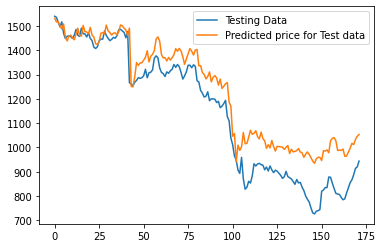

In [182]:
plt.plot(inv_y,label='Testing Data')
plt.plot(predictions,label='Predicted price for Test data')
plt.legend();

In [87]:
#Calculate average price of the stock based on last 5 days of test data 
avg_test_x=inv_test_data[:,(0,5,10,15,20)].mean(axis=1)

In [88]:
avg_test_x.shape

(172,)

In [89]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, avg_test_x))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 53.648


In [196]:
# Update LSTM model
def update_model(model, train_X,train_y ,batch_size, updates,timesteps):
	X, y = train_X, train_y
	#X = X.reshape(X.shape[0], timesteps, X.shape[1])
	for i in range(updates):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
		model.reset_states()

In [198]:
train_X_copy = np.copy(train_X)
train_y_copy = np.copy(train_y)
print(train_X_copy.shape)
print(train_y_copy.shape)
# make a prediction for test data
predictions = list()
for i in range(test_X.shape[0]):
  if i > 0:
    update_model(model, train_X=train_X_copy,train_y=train_y_copy, batch_size=1, updates=2,timesteps=n_timesteps)
  # predict
  X, y = test_X[i], test_y[i,-1]
  #print(X,y)
  yhat = forecast_lstm(model, 1, X,timesteps=n_timesteps)
  X=X.reshape(1,n_timesteps* n_features)
  # invert scaling  
  #print(X.shape)
  #print(yhat)
  yhat= invert_scale(scaler, X, yhat)
  # store forecast
  predictions.append(yhat)
  # add to training set
  train_X_copy = concatenate((train_X_copy, test_X[i].reshape(1,n_timesteps, n_features)))
  train_y_copy = concatenate((train_y_copy, test_y[i]))
  #.reshape(1, -1)
print(train_X_copy.shape)
print(train_y_copy.shape)


(684, 5, 5)
(684,)
685/685 - 1s - loss: 4.9231e-04 - accuracy: 0.0029
685/685 - 1s - loss: 4.3592e-04 - accuracy: 0.0029
686/686 - 1s - loss: 5.0939e-04 - accuracy: 0.0029
686/686 - 1s - loss: 4.0655e-04 - accuracy: 0.0029
687/687 - 1s - loss: 4.3371e-04 - accuracy: 0.0029
687/687 - 1s - loss: 4.6627e-04 - accuracy: 0.0029
688/688 - 1s - loss: 4.6915e-04 - accuracy: 0.0029
688/688 - 1s - loss: 4.8673e-04 - accuracy: 0.0029
689/689 - 1s - loss: 6.6869e-04 - accuracy: 0.0029
689/689 - 1s - loss: 6.0721e-04 - accuracy: 0.0029
690/690 - 1s - loss: 4.5905e-04 - accuracy: 0.0029
690/690 - 1s - loss: 4.3591e-04 - accuracy: 0.0029
691/691 - 1s - loss: 6.0570e-04 - accuracy: 0.0029
691/691 - 1s - loss: 5.2332e-04 - accuracy: 0.0029
692/692 - 1s - loss: 4.7872e-04 - accuracy: 0.0029
692/692 - 1s - loss: 4.4804e-04 - accuracy: 0.0029
693/693 - 1s - loss: 4.0327e-04 - accuracy: 0.0029
693/693 - 1s - loss: 4.2646e-04 - accuracy: 0.0029
694/694 - 1s - loss: 5.7187e-04 - accuracy: 0.0029
694/694 - 1s

In [200]:
from math import sqrt

#print(predictions.shape)
inv_y = test_data[target_stock+'(t)'].values
print(inv_y.shape)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, predictions))
print('Test RMSE: %.3f' % rmse)

(172,)
Test RMSE: 66.913


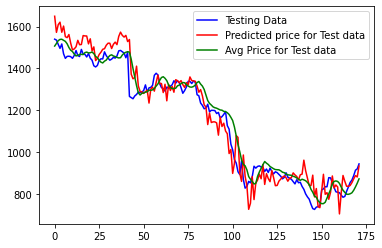

In [201]:
plt.plot(inv_y,label='Testing Data', color='blue')
plt.plot(predictions,label='Predicted price for Test data',color='red')
plt.plot(avg_test_x,label='Avg Price for Test data',color='green')
plt.legend();